# **Data Cleaning and Feature Engineering**

## Objectives

1. Clean dataset
2. Engineer new features
3. Transform features in preparation for ML modelling

## Inputs

- acled_original_optimised.csv file

## Outputs

1. Cleaned data set
2. ML modelling-ready input data set (with Feature Engineering)

## Additional Comments

<ins>Cleaning list from EDA notebook</ins>

1. actor2, inter2, population_1km, population_best, deal with missing values
2. disorder_type, has only 1 value type, drop
3. Consider dropping:
    - actor1/actor2 (name of beligerent), many unique values, difficult to interpret
3. interaction, check if column value can be grouped together
4. source, try to recategorise values, too many in current state
5. source_scale, try to recategorise values, note category 'Other'
6. Create additional dataset for DBSCAN without geo_precision = 3



In [347]:
# import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load dataset 

In [348]:
# use the same loading procedure as in the previous notebook

# specify columns to keep
to_keep = ['event_id_cnty', 'event_date', 'disorder_type', 'event_type', 'sub_event_type', 'actor1', 
           'inter1', 'actor2', 'inter2', 'interaction', 'region', 'country', 'latitude', 'longitude',
           'geo_precision', 'source', 'source_scale','notes',  'fatalities',  'population_1km', 
           'population_best']

# define data types for each column
dtype_map = {
    "event_id_cnty": "string",           
    "disorder_type": "category",
    "event_type": "category",
    "sub_event_type": "category",
    "actor1": "category",
    "inter1": "category",                   
    "actor2": "category",
    "inter2": "category",                 
    "interaction": "category",               
    "region": "category",
    "country": "category",
    "latitude": "float32",
    "longitude": "float32",
    "geo_precision": "int8",           
    "source": "category",
    "source_scale": "category",
    "notes": "string",                   
    "fatalities": "int16",               
    "population_1km": "float32",       
    "population_best": "float32"    
}

# load the dataset with specified columns and data types
df = pd.read_csv(
    Path.cwd().parent / 'data/raw/original_acled.csv',
    usecols=to_keep,
    dtype=dtype_map,
    parse_dates=["event_date"],
    low_memory=False
)

# Data Cleaning

## Drop columns

Not all columns are useful for the upcoming analysis. Columns may be dropped for 3 reasons:

1. They are irrelevant, i.e. they contain no useful info 
2. They may contain relevant info, but it cannot be extracted and they cannot be used as they are 
3. They are redundant, i.e. several columns with roughly the same info. <ins>This would damage the model!</ins>

In [349]:
# 'disorder_type' is irrelevant as it has only one value, so it will be dropped
df.drop(columns=['disorder_type'], inplace=True)

In [350]:
# 'event_type' is useful, but the analysis will mainly focus on spatial aspects
# will drop for now
df.drop(columns=['event_date'], inplace=True)

In [351]:
# "actor1" and "actor2" provide the names of belligerents, e.g. 'Military Forces of Eritrea'
# these values are too granular (too many unique values), cannot be used
df.drop(columns=['actor1', 'actor2'], inplace=True)

In [352]:
# "inter1" and "inter2" provide the type of belligerents, e.g. 'State Forces'
# these values are more general and can be used, but they are redundant with "interaction"
# "interaction" combines both sides, e.g. 'State Forces vs. Non-State Forces'
# therefore, only "interaction" will be kept to reduce dimensionality
df.drop(columns=['inter1', 'inter2'], inplace=True)

In [353]:
# 'population_1km' and 'population_best' are highly correlated, so only one will be kept
df.drop(columns=['population_1km'], inplace=True)

In [354]:
# "source" contains the source of the report, e.g. 'BBC'
# this is too granular, not that useful for the analysis, also 'source_scale' ('Local News') is more relevant
df.drop(columns=['source'], inplace=True)

In [355]:
# "notes" contains unstructured text data about the event
# it may contain useful key words, but for the scopre of this project, it will be dropped
df.drop(columns=['notes'], inplace=True)

## Recategorisation

In [356]:
# 'source_scale' must be retained as it provides useful information about the reliability of the report
# however it contains 26 unique values, which is too many for one-hot encoding
# therefore, they will be re-categorised empirically into fewer groups based on geo scale

source_scale_mapping = {
    # LOCAL / SUBNATIONAL
    'Subnational': 'Local/Subnational',
    'Local partner-Other': 'Local/Subnational',
    'Local partner-Regional': 'Local/Subnational',
    'Local partner-National': 'Local/Subnational',
    'Local partner-New media': 'Local/Subnational',
    'Local partner-International': 'Local/Subnational',
    'Subnational-National': 'Local/Subnational',
    'Other-Subnational': 'Local/Subnational',
    'New media-Subnational': 'Local/Subnational',
    'Subnational-Regional': 'Local/Subnational',
    'Subnational-International': 'Local/Subnational',
    # NATIONAL
    'National': 'National',
    'National-Regional': 'National',
    'National-International': 'National',
    'Other-National': 'National',
    'New media-National': 'National',
    # REGIONAL
    'Regional': 'Regional',
    'Regional-International': 'Regional',
    'Other-Regional': 'Regional',
    'New media-Regional': 'Regional',
    # INTERNATIONAL
    'International': 'International',
    'Other-International': 'International',
    'New media-International': 'International',
    # PURE NEW MEDIA
    'New media': 'New media',
    'Other-New media': 'New media',
    # OTHER
    'Other': 'Other'
}

# apply mapping
df["source_scale"] = df["source_scale"].map(source_scale_mapping)

In [357]:
# same for 'regions'

region_mapping = {
    # Africa (merge all African subregions)
    'Africa': 'Africa',
    'Middle Africa': 'Africa',
    'Northern Africa': 'Africa',
    'Southern Africa': 'Africa',
    'Western Africa': 'Africa',
    'Eastern Africa': 'Africa',

    # Middle East
    'Middle East': 'Middle East',

    # Asia
    'South Asia': 'Asia',
    'Southeast Asia': 'Asia',
    'East Asia': 'Asia',
    'Central Asia': 'Asia',
    'Caucasus and Central Asia': 'Asia',

    # Europe
    'Europe': 'Europe',
    'Central Europe': 'Europe',
    'Eastern Europe': 'Europe',

    # Americas
    'South America': 'Americas',
    'Central America': 'Americas',
    'North America': 'Americas',
    'Caribbean': 'Americas',

    # Oceania / Other
    'Oceania': 'Oceania',
    'Australia': 'Oceania',
    'Pacific Islands': 'Oceania',

    # Catch-all (in case ACLED returns unexpected labels)
    'Other': 'Oceania'
}

df['region'] = df['region'].map(region_mapping)

In [358]:
df['region'].value_counts()

region
Middle East    299104
Europe         204309
Asia           202113
Africa         196417
Americas       163277
Oceania            92
Name: count, dtype: int64

In [359]:
# drop 'Oceania' due to low number of events
df = df[df['region'] != 'Oceania']

## Missing values

In [360]:
# review nans
df.isna().sum()

event_id_cnty          0
event_type             0
sub_event_type         0
interaction            0
region                 0
country                0
latitude               0
longitude              0
geo_precision          0
source_scale           0
fatalities             0
population_best    48294
dtype: int64

Column 'population_best' represents an estimate of the population density of the area where an event was reported.

Options:

1. Global median imputation - not recommended as it can lead to drastic departures from reality
2. Median imputation based on 'country' and 'region' - not perfect, but much more accurate than the above

<ins>Choose Option 2</ins>

In [361]:
# first try with 'country'
df["population_best"] = df.groupby("country")["population_best"].transform(lambda x: x.fillna(x.median()))

# check if all nans were filled
df.isna().sum()

/var/folders/6d/4qqmbbk90jg_rr8cp3n70klw0000gn/T/ipykernel_3593/239464154.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["population_best"] = df.groupby("country")["population_best"].transform(lambda x: x.fillna(x.median()))


event_id_cnty      0
event_type         0
sub_event_type     0
interaction        0
region             0
country            0
latitude           0
longitude          0
geo_precision      0
source_scale       0
fatalities         0
population_best    0
dtype: int64

## Outliers

In [362]:
# there are only 3 columns that could potentially have outliers
df[['fatalities', 'population_best']].describe()

,fatalities,population_best
count,1.065220e+06,1.065220e+06
mean,1.602319e+00,6.024737e+04
std,6.770092e+00,1.382695e+05
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.446000e+03
50%,0.000000e+00,9.565000e+03
75%,1.000000e+00,4.694700e+04
max,1.000000e+03,1.854773e+06


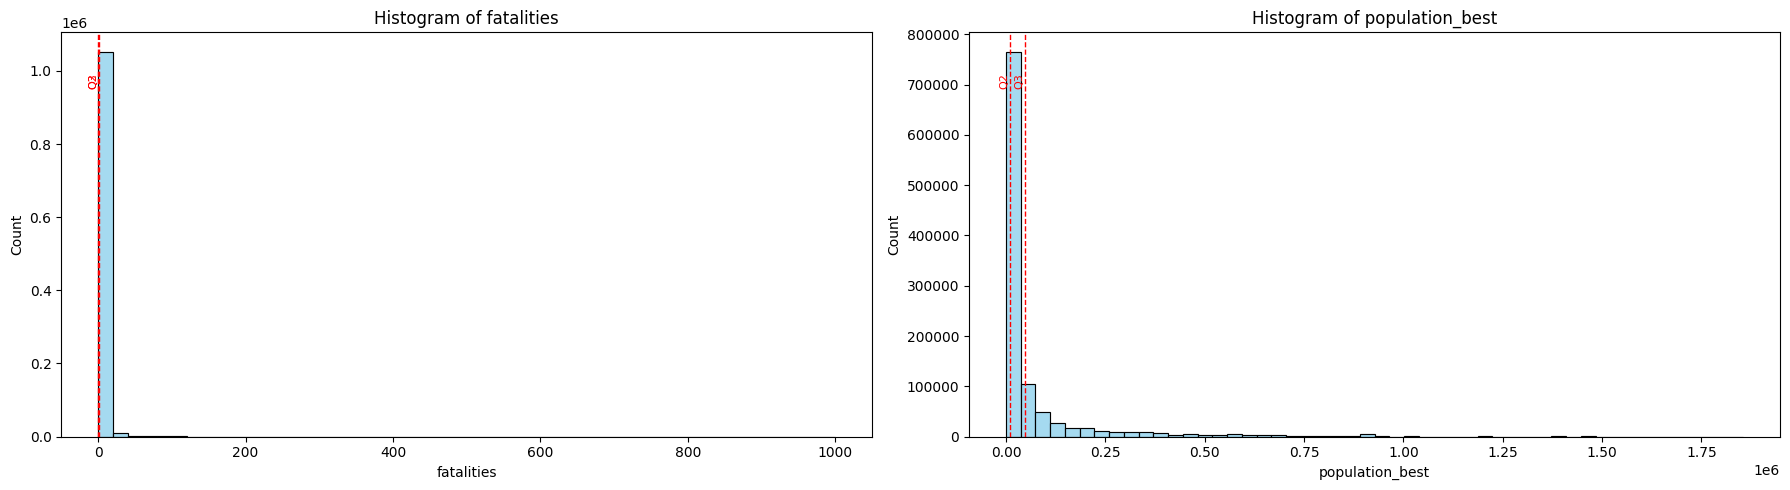

In [363]:
# visualize distributions and quartiles to identify outliers

cols = ["fatalities", "population_best"]

# create figure
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
for ax, col in zip(axes, cols):
    data = df[col].dropna()

    # create histogram
    sns.histplot(data, bins=50, kde=False, ax=ax, color="skyblue")
    # calculate quartiles
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    # draw lines for Q2 and Q3
    for q, label in zip([q2, q3], ["Q2", "Q3"]):
        ax.axvline(q, color="red", linestyle="--", linewidth=1)
        ax.text(
            q, 
            ax.get_ylim()[1] * 0.9, 
            label, 
            rotation=90, 
            verticalalignment="top", 
            horizontalalignment="right",
            fontsize=8,
            color="red"
        )

    # add titles and labels
    ax.set_title(f"Histogram of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

<ins>**'fatalities'**</ins> as shown in the EDA, there is a heavy tail here, which implicitly means outliers. However, it is exactly this tail, i.e. the outliers, that we want model. Will NOT remove the outliers.

<ins>**'population_1km' & 'population_best'**</ins> both have a exponential distribution and likely many outliers. However, this is normal for population distributions. ACLED's quality is considered high and, unlike 'fatalities', population density measurements come from reputable sources. No reason to believe that there would be erroneous outliers - all outliers represent legitimate demographics and will NOT be removed.


In [364]:
# save cleaned dataset
df.to_csv(Path.cwd().parent / 'data/clean/acled_clean.csv', index=False)

# Feature Engineering

DBSCAN will be used to cluster the conflicts (see explanation in notebook 03_modelling). This algorithm has the following requirements:

1. Reduced dimensionality - cannot handle a high amount of predictor variables
2. Categorical data is encoded
3. No extreme magnitudes - as the algorithm is based on Euclidean distance, large values would dominate. As such:
    - Convert to logarithmic scale - this reduces the skewness: compresses the tail whilst preserving relative distances. BUT does not affect scale.
    - Rescale using Z-score normalisation - assures that all numericals contribute equally to DBSCAN's distance calculations.
4. Remove artificial clusters: events with 'geo_precision' = 3 have inaccurate coordinates based on centroids (see notebook 01_eda). Will remove. 

In [365]:
# create copy for feature engineering
df_input = df.copy()
# set index to event_id_cnty for easier referencing after one-hot encoding
df_input = df_input.set_index("event_id_cnty")

In [366]:
# as DBSCAN cannot handle high dimensionality, "country" and "sub_event_type" will be dropped
df_input.drop(columns=['country', 'sub_event_type'], inplace=True)

In [367]:
# drop rows with geo_precision == 3 (low precision)
df_input.drop(df_input[df_input['geo_precision'] == 3].index, axis=0, inplace=True)

# drop column 'geo_precision' as it is not useful on its own
df_input.drop(columns=['geo_precision'], inplace=True)

<ins>NOTE<ins>

Normally I'd be using OneHot Encoding for categorical variables, but in this case it will increase the dimensionality past the point that DBSCAN (...or my laptop) can handle.

As such, will use alternatives, such as ordinal numeric codes. For example, in the case of 'interaction': if state = 1 and civilian = 2, then state vs civilian = 12.


In [368]:
# ordinal encoding for 'interaction', .codes finds automatically the integer codes
interaction_cat = pd.Categorical(df_input["interaction"])
df_input["interaction_code"] = interaction_cat.codes

# for 'region' and 'source_scale', manual ordinal encoding based on domain knowledge
region_order = {
    "Africa": 0,
    "Middle East": 1,
    "Asia": 2,
    "Europe": 3,
    "Americas": 4,
    "Oceania": 5
}
df_input["region_code"] = df_input["region"].map(region_order)

source_scale_order = {
    "Local/Subnational": 0,
    "National": 1,
    "Regional": 2,
    "International": 3,
    "New media": 4,
    "Other": 5
}
df_input["source_scale_code"] = df_input["source_scale"].map(source_scale_order)

# for 'event_type' one-hot encoding can be used as there are only 3 unique values
df_dummies = pd.get_dummies(df_input['event_type'], drop_first=False).astype(int)
df_input = pd.concat([df_input, df_dummies], axis=1)

# drop original categorical columns after encoding
df_input.drop(columns=['interaction', 'region', 'source_scale', 'event_type'], inplace=True)

In [369]:
# rescale the numerical columns to logarithmic scale to reduce the impact of outliers
df_input["fatalities_log"] = np.log1p(df_input["fatalities"])
df_input["popbest_log"] = np.log1p(df_input["population_best"])

# drop the original columns
df_input.drop(columns=['fatalities', 'population_best'], inplace=True)

In [370]:
# rescale all numericals using StandardScaler
numeric_cols = ["latitude", "longitude", "fatalities_log", "popbest_log"]

# create and apply StandardScaler
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df_input[numeric_cols])

# Convert back to DataFrame for clarity
numeric_scaled = pd.DataFrame(numeric_scaled, columns=numeric_cols, index=df_input.index)

# drop original cols and concatenate new ones
df_input.drop(columns = numeric_cols, inplace=True)
df_input = pd.concat([df_input, numeric_scaled], axis=1)

In [371]:
df_input.head()

,interaction_code,region_code,source_scale_code,Battles,Explosions/Remote violence,Violence against civilians,latitude,longitude,fatalities_log,popbest_log
event_id_cnty,,,,,,,,,,
MMR1,22,2,1,0,0,1,-0.468217,1.475288,-0.635619,0.032106
SOM5580,12,0,1,1,0,0,-1.206303,0.373083,2.174686,0.508382
BGD7238,12,2,3,1,0,0,-0.017665,1.301700,-0.635619,0.947155
ETH1319,23,0,3,1,0,0,-0.550208,0.264852,2.605068,0.473814
ETH1320,23,0,3,1,0,0,-0.549523,0.263641,2.605068,0.473814


In [372]:
# save feature set
df_input.to_csv(Path.cwd().parent / 'data/final/dbscan_input.csv', index=True)